# Graph Classification with DGL

Here we demonstrate how to use DGL to finish graph classification tasks. The dataset we use here is Tox21, a public database measuring toxicity of compounds.  The dataset contains qualitative toxicity measurements for 8014 compounds on 12 different targets, including nuclear receptors and stress response pathways. 

In [16]:
import dgl
from dgl.data.chem import Tox21
from dgl import model_zoo
from dgl.data.utils import split_dataset

In [17]:
from rdkit import Chem
from rdkit.Chem import Draw,MolFromSmiles, MolToSmiles

In [18]:
import torch
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm import tqdm

## Load Dataset

This would take about one minute

In [7]:
dataset = Tox21()

Loading previously saved dgl graphs...


### Split dataset into train and val

In [8]:
trainset, valset = split_dataset(dataset, [0.8, 0.2], shuffle=True, random_state=42)

Each target label in a binary label. A common issue for multi-task prediction is that some datapoints are not labeled for all tasks. This is also the case for Tox21. In data pre-processing, we set non-existing labels to be 0 and corresponding mask value to be 0 too. The label below means NR-AhR has positive labels, and NR-Aromatase and NR-ER's labels are missing.

In [9]:
smile, graph, label, mask = dataset[0]
print(dataset.task_names)
print(smile)
print(label)
print(mask)

['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER', 'NR-ER-LBD', 'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53']
CCOc1ccc2nc(S(N)(=O)=O)sc2c1
tensor([0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
tensor([1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.])


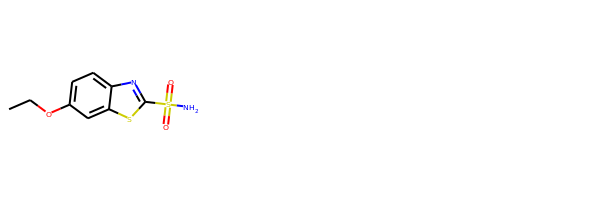

In [10]:
Draw.MolsToGridImage([MolFromSmiles(smile)])

Each atom can be considered as a node in graph, and the bond between them are the edges. We use [`CanonicalAtomFeaturizer`](https://docs.dgl.ai/generated/dgl.data.chem.CanonicalAtomFeaturizer.html#dgl.data.chem.CanonicalAtomFeaturizer), a fingerprint method to create feature for each node.

In [19]:
graph.ndata['h']

tensor([[1., 0., 0.,  ..., 0., 1., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 1., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

## Prepare Dataloader

DGL could batch multiple small graphs together to accelerate the computation. Detail of batching can be found [here](https://docs.dgl.ai/tutorials/basics/4_batch.html).

<img src="https://s3.us-east-2.amazonaws.com/dgl.ai/tutorial/batch/batch.png" width="500"/>

In [12]:
def collate_molgraphs_for_classification(data):
    """Batching a list of datapoints for dataloader in classification tasks."""
    smiles, graphs, labels, mask = map(list, zip(*data))
    bg = dgl.batch(graphs)
    labels = torch.stack(labels, dim=0)
    mask = torch.stack(mask, dim=0)
    return smiles, bg, labels, mask

train_loader = DataLoader(trainset, batch_size= 1024,
                          collate_fn=collate_molgraphs_for_classification)
val_loader = DataLoader(valset, batch_size= len(valset),
                        collate_fn=collate_molgraphs_for_classification)

## Prepare Model and Optimizer

Here we use a two layer Graph Convolutional Network to classify the graphs. Detailed source code can be found [here](https://github.com/dmlc/dgl/blob/master/python/dgl/model_zoo/chem/classifiers.py#L111).

In [13]:
model = model_zoo.chem.GCNClassifier(in_feats=74, gcn_hidden_feats=[128, 64], n_tasks=12).cuda()
loss_criterion = BCEWithLogitsLoss(reduction='none')
optimizer = Adam(model.parameters())
print(model)

GCNClassifier(
  (gnn_layers): ModuleList(
    (0): GCNLayer(
      (graph_conv): GraphConv(in=74, out=128, normalization=False, activation=<function relu at 0x7ff23f3af510>)
      (dropout): Dropout(p=0.0)
      (res_connection): Linear(in_features=74, out_features=128, bias=True)
      (bn_layer): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): GCNLayer(
      (graph_conv): GraphConv(in=128, out=64, normalization=False, activation=<function relu at 0x7ff23f3af510>)
      (dropout): Dropout(p=0.0)
      (res_connection): Linear(in_features=128, out_features=64, bias=True)
      (bn_layer): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (weighted_sum_readout): WeightAndSum(
    (atom_weighting): Sequential(
      (0): Linear(in_features=64, out_features=1, bias=True)
      (1): Sigmoid()
    )
  )
  (soft_classifier): MLPBinaryClassifier(
    (predict): Sequential(
      (0): Dropout(p=0.0)
   

### Training

In [69]:
epochs = 50
model.train()
for i in tqdm(range(epochs)):
    for batch_id, batch_data in enumerate(train_loader):
        smiles, bg, labels, mask = batch_data
        atom_feats = bg.ndata.pop('h')
        atom_feats, labels, mask = atom_feats.to('cuda'), \
                                   labels.to('cuda'), \
                                   mask.to('cuda')
        logits = model(bg, atom_feats)
        # Mask non-existing labels
        loss = (loss_criterion(logits, labels) * (mask != 0).float()).mean()
        if batch_id % 20 == 0:
            tqdm.write("Loss: {}".format(loss.item()))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  0%|          | 0/50 [00:00<?, ?it/s]

Loss: 0.039240747690200806


  2%|▏         | 1/50 [00:00<00:37,  1.29it/s]

Loss: 0.04174252599477768


  4%|▍         | 2/50 [00:01<00:36,  1.31it/s]

Loss: 0.03991314023733139


  6%|▌         | 3/50 [00:02<00:35,  1.32it/s]

Loss: 0.03849509358406067


  8%|▊         | 4/50 [00:03<00:34,  1.32it/s]

Loss: 0.03620683774352074


 10%|█         | 5/50 [00:04<00:38,  1.17it/s]

Loss: 0.03446788713335991


 12%|█▏        | 6/50 [00:04<00:36,  1.21it/s]

Loss: 0.034364115446805954


 14%|█▍        | 7/50 [00:05<00:34,  1.24it/s]

Loss: 0.032457493245601654


 16%|█▌        | 8/50 [00:06<00:33,  1.27it/s]

Loss: 0.03503230959177017


 18%|█▊        | 9/50 [00:07<00:32,  1.28it/s]

Loss: 0.031008627265691757


 20%|██        | 10/50 [00:07<00:31,  1.29it/s]

Loss: 0.035214293748140335


 22%|██▏       | 11/50 [00:08<00:30,  1.28it/s]

Loss: 0.031359586864709854


 24%|██▍       | 12/50 [00:09<00:30,  1.26it/s]

Loss: 0.038301095366477966


 26%|██▌       | 13/50 [00:10<00:29,  1.27it/s]

Loss: 0.03370219096541405


 28%|██▊       | 14/50 [00:11<00:27,  1.29it/s]

Loss: 0.03406341001391411


 30%|███       | 15/50 [00:11<00:26,  1.32it/s]

Loss: 0.032088786363601685


 32%|███▏      | 16/50 [00:12<00:26,  1.31it/s]

Loss: 0.03040865622460842


 34%|███▍      | 17/50 [00:13<00:24,  1.33it/s]

Loss: 0.029525702819228172


 36%|███▌      | 18/50 [00:14<00:23,  1.35it/s]

Loss: 0.027573686093091965


 38%|███▊      | 19/50 [00:14<00:23,  1.32it/s]

Loss: 0.027876494452357292


 40%|████      | 20/50 [00:15<00:22,  1.34it/s]

Loss: 0.02600916475057602


 42%|████▏     | 21/50 [00:16<00:21,  1.34it/s]

Loss: 0.027585333213210106


 44%|████▍     | 22/50 [00:17<00:20,  1.35it/s]

Loss: 0.025417745113372803


 46%|████▌     | 23/50 [00:17<00:20,  1.33it/s]

Loss: 0.0258383359760046


 48%|████▊     | 24/50 [00:18<00:19,  1.31it/s]

Loss: 0.0246858112514019


 50%|█████     | 25/50 [00:19<00:19,  1.29it/s]

Loss: 0.024637766182422638


 52%|█████▏    | 26/50 [00:20<00:18,  1.31it/s]

Loss: 0.024306878447532654


 54%|█████▍    | 27/50 [00:20<00:17,  1.31it/s]

Loss: 0.023209180682897568


 56%|█████▌    | 28/50 [00:21<00:18,  1.18it/s]

Loss: 0.022858021780848503


 58%|█████▊    | 29/50 [00:22<00:17,  1.23it/s]

Loss: 0.02225784957408905


 60%|██████    | 30/50 [00:23<00:15,  1.28it/s]

Loss: 0.0224414374679327


 62%|██████▏   | 31/50 [00:24<00:14,  1.30it/s]

Loss: 0.02055797539651394


 64%|██████▍   | 32/50 [00:24<00:13,  1.29it/s]

Loss: 0.020824545994400978


 66%|██████▌   | 33/50 [00:25<00:13,  1.28it/s]

Loss: 0.020850878208875656


 68%|██████▊   | 34/50 [00:26<00:12,  1.31it/s]

Loss: 0.02198857069015503


 70%|███████   | 35/50 [00:27<00:11,  1.33it/s]

Loss: 0.019175907596945763


 72%|███████▏  | 36/50 [00:27<00:10,  1.35it/s]

Loss: 0.022818949073553085


 74%|███████▍  | 37/50 [00:28<00:09,  1.36it/s]

Loss: 0.021116113290190697


 76%|███████▌  | 38/50 [00:29<00:08,  1.37it/s]

Loss: 0.02645183354616165


 78%|███████▊  | 39/50 [00:30<00:07,  1.38it/s]

Loss: 0.023870721459388733


 80%|████████  | 40/50 [00:30<00:07,  1.38it/s]

Loss: 0.02198125049471855


 82%|████████▏ | 41/50 [00:31<00:06,  1.39it/s]

Loss: 0.024205923080444336


 84%|████████▍ | 42/50 [00:32<00:05,  1.37it/s]

Loss: 0.023719295859336853


 86%|████████▌ | 43/50 [00:32<00:05,  1.38it/s]

Loss: 0.022897925227880478


 88%|████████▊ | 44/50 [00:33<00:04,  1.39it/s]

Loss: 0.019991744309663773


 90%|█████████ | 45/50 [00:34<00:03,  1.39it/s]

Loss: 0.018998239189386368


 92%|█████████▏| 46/50 [00:35<00:02,  1.39it/s]

Loss: 0.018907755613327026


 94%|█████████▍| 47/50 [00:35<00:02,  1.35it/s]

Loss: 0.019363436847925186


 96%|█████████▌| 48/50 [00:36<00:01,  1.32it/s]

Loss: 0.016610924154520035


 98%|█████████▊| 49/50 [00:37<00:00,  1.32it/s]

Loss: 0.016279257833957672


100%|██████████| 50/50 [00:38<00:00,  1.31it/s]


### Inference

In [15]:
model.eval()
with torch.no_grad():
    for batch_id, batch_data in enumerate(tqdm(val_loader)):
        smiles, bg, labels, mask = batch_data
        atom_feats = bg.ndata.pop('h')
        atom_feats, labels, mask = atom_feats.to('cuda'), \
                                   labels.to('cuda'), \
                                   mask.to('cuda')
        logits = model(bg, atom_feats)
        accuracy_overall_tasks = (((logits>0)==labels.byte()).float()*mask).sum()/mask.sum()
        print(accuracy_overall_tasks)

  0%|          | 0/1 [00:00<?, ?it/s]

NameError: name 'dgl' is not defined

We acheived a pretty high accuracy. However, this dataset's labels are imbalanced, which means most labels could be negative. Therefore it would be unfair to evaluate result with accuracy score. A more detailed analysis of this task could be found at our [model zoo](https://github.com/dmlc/dgl/tree/master/examples/pytorch/model_zoo/chem/property_prediction).